# Store Sales - Time Series Forecasting

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [3]:
data_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
data_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
data_oil = pd.read_csv('//kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
data_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
data_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
data_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])

In [4]:
print('data_test shape:', data_test.shape)
print('data_train shape:', data_train.shape)
print('data_oil shape:', data_oil.shape)
print('data_stores shape:', data_stores.shape)
print('data_transactions shape:', data_transactions.shape)
print('data_holidays shape:', data_holidays.shape)

data_test shape: (28512, 5)
data_train shape: (3000888, 6)
data_oil shape: (1218, 2)
data_stores shape: (54, 5)
data_transactions shape: (83488, 3)
data_holidays shape: (350, 6)


## Data Description

In [5]:
print(data_test.head())

        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0


In [6]:
print(data_train.head())

   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0


In [7]:
print(data_oil.head())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


In [8]:
print(data_stores.head())

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4


In [9]:
print(data_holidays.head())

        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


In [10]:
print(data_transactions.head())

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922


In [11]:
print("Amount of stores: ", data_train['store_nbr'].nunique())
print("Amount of product families: ", data_train['family'].nunique())
print("Train data starts on", data_train['date'].min().date(), "and ends on", data_train['date'].max().date(), "with a total of", data_train['date'].nunique(), "days.")
print("Test data starts on", data_test['date'].min().date(), "and ends on", data_test['date'].max().date(), "with a total of", data_test['date'].nunique(), "days.")
print("Oil data starts on", data_oil['date'].min().date(), "and ends on", data_oil['date'].max().date(), "with a total of", data_oil['date'].nunique(), "days.")
print("Transactions data starts on", data_transactions['date'].min().date(), "and ends on", data_transactions['date'].max().date(), "with a total of", data_transactions['date'].nunique(), "days.")

Amount of stores:  54
Amount of product families:  33
Train data starts on 2013-01-01 and ends on 2017-08-15 with a total of 1684 days.
Test data starts on 2017-08-16 and ends on 2017-08-31 with a total of 16 days.
Oil data starts on 2013-01-01 and ends on 2017-08-31 with a total of 1218 days.
Transactions data starts on 2013-01-01 and ends on 2017-08-15 with a total of 1682 days.


In [12]:
data_train_range = pd.date_range(start = data_train['date'].min(), end = data_train['date'].max())

print("Number of days in calendar: ", len(data_train_range))
print("Number of days in train data: ", data_train['date'].nunique())
print("Missing dates in train data: ", data_train_range.difference(data_train['date']))

Number of days in calendar:  1688
Number of days in train data:  1684
Missing dates in train data:  DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [13]:
data_transactions_range = pd.date_range(start = data_transactions['date'].min(), end = data_transactions['date'].max())

print("Number of days in calendar: ", len(data_transactions_range))
print("Number of days in train data: ", data_transactions['date'].nunique())
print("Missing dates in train data: ", data_transactions_range.difference(data_transactions['date']))

Number of days in calendar:  1688
Number of days in train data:  1682
Missing dates in train data:  DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-01-01',
               '2016-01-03', '2016-12-25'],
              dtype='datetime64[ns]', freq=None)


In [14]:
data_oil_range = pd.date_range(start = data_oil['date'].min(), end = data_oil['date'].max())
total_weekends = data_oil_range.weekday.isin([5, 6]).sum()

print("Number of weekends in oil data: ", total_weekends)
print("Number of days missing in oil data: ", data_oil_range.difference(data_oil['date']).nunique())

Number of weekends in oil data:  486
Number of days missing in oil data:  486


In [15]:
print("Types of holidays: ", data_holidays['type'].unique())
print("Holidays that fall on the test data set: ", data_holidays[data_holidays['date'].isin(data_test['date'])]['description'].unique())
print("Number of transferred holidays: ", len(data_holidays[data_holidays['transferred'] == True]))
print("Number of events: ", len(data_holidays[data_holidays['type'] == 'Event']))
print("Locations that have events: ", data_holidays[data_holidays['type'] == 'Event']['locale_name'].unique())
print("Number of local holidays or additional days: ", len(data_holidays[(data_holidays['locale'] == 'Local') & (data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))]))
print("Locations that have a local holiday or additional days: ", data_holidays[(data_holidays['locale'] == 'Local') & (data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))]['locale_name'].unique())
print("Number of regional holidays or additional days: ", len(data_holidays[(data_holidays['locale'] == 'Regional') & (data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))]))
print("Locations that have a regional holiday or additional days: ", data_holidays[(data_holidays['locale'] == 'Regional') & (data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))]['locale_name'].unique())
print("Number of national holidays or additional days: ", len(data_holidays[(data_holidays['locale'] == 'National') & (data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))]))
print("Unique locations with national holidays or additional days: ", data_holidays[(data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge'])) & (data_holidays['locale'] == 'National')]['locale_name'].unique())

earthquake_start_date = data_holidays[data_holidays['description'].str.contains('terremoto', case=False)]['date'].values[0]
earthquake_end_date = data_holidays[data_holidays['description'].str.contains('terremoto', case=False)]['date'].values[-1]
earthquake_range = pd.date_range(start = earthquake_start_date, end = earthquake_end_date)

print("The earthquake and its aftermath affected Ecuador for", len(earthquake_range), "days, from ", earthquake_start_date, "to", earthquake_end_date)

Types of holidays:  ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holidays that fall on the test data set:  ['Fundacion de Ambato']
Number of transferred holidays:  12
Number of events:  56
Locations that have events:  ['Ecuador']
Number of local holidays or additional days:  148
Locations that have a local holiday or additional days:  ['Manta' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda' 'Latacunga'
 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe' 'Esmeraldas' 'Ambato'
 'Ibarra' 'Quevedo' 'Quito' 'Loja' 'Salinas' 'Guayaquil']
Number of regional holidays or additional days:  24
Locations that have a regional holiday or additional days:  ['Cotopaxi' 'Imbabura' 'Santo Domingo de los Tsachilas' 'Santa Elena']
Number of national holidays or additional days:  105
Unique locations with national holidays or additional days:  ['Ecuador']
The earthquake and its aftermath affected Ecuador for 31 days, from  2016-04-16T00:00:00.000000000 to 2016-05-16T00:00:00.000000000


From observing the data we can find:

1. The training data is from 2013-01-01 to 2017-08-15 and the only missing values in it are Christmas days (4 in total). We will fill these in.
2. The oil date is from 2013-01-01 to 2017-08-31. As is expected, the oil price is missing on weekends. We will fill these in as well.
3. The transactions data is from 2013-01-01 to 2017-08-15. There are missing values in this dataset, which we will fill in with 0, as it seems to be dates where there were no transactions.
3. We have 12 holidays which were transferred, meaning that the day was essentially a regular day.
4. We have 3 different types of holidays: local, regional and national. The local ones affect the city, the regional ones affect a province and the national ones affect the whole country.
5. There are events that are not holidays but are marked as important. They affect the whole country.
6. The earthquake and its aftermath affected Ecuador during 31 days, from  2016-04-16 to 2016-05-16

A very nice piece of information provided beforehand is that the wages in the public sector are paid every two weeks on the 15th and on the last day of the month.

## Data preprocessing

We will start by filling in the gaps in the data, as mentioned above.

In [16]:
stores = data_train['store_nbr'].unique()
families = data_train['family'].unique()

full_index = pd.MultiIndex.from_product([stores, families, data_train_range], names=['store_nbr', 'family', 'date'])

processed_data_train = data_train.copy()

processed_data_train.set_index(['store_nbr', 'family', 'date'], inplace=True)

processed_data_train = processed_data_train.reindex(full_index, fill_value=0).reset_index()


In [17]:
processed_data_train_range = pd.date_range(start = processed_data_train['date'].min(), end = processed_data_train['date'].max())

print("Number of days in calendar: ", len(processed_data_train_range))
print("Number of days in train data: ", processed_data_train['date'].nunique())
print("Missing dates in train data: ", processed_data_train_range.difference(processed_data_train['date']))

Number of days in calendar:  1688
Number of days in train data:  1688
Missing dates in train data:  DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [18]:
processed_data_oil = data_oil.copy()

processed_data_oil = pd.merge(pd.DataFrame({'date': data_oil_range}), processed_data_oil, on='date', how='left')

processed_data_oil['dcoilwtico'] = processed_data_oil['dcoilwtico'].fillna(method='bfill')


/tmp/ipykernel_18/604030787.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_data_oil['dcoilwtico'] = processed_data_oil['dcoilwtico'].fillna(method='bfill')


In [19]:
processed_data_oil_range = pd.date_range(start = processed_data_oil['date'].min(), end = processed_data_oil['date'].max())

print("Number of days in calendar: ", len(processed_data_oil_range))
print("Number of days in oil data: ", processed_data_oil['date'].nunique())
print("Missing dates in oil data: ", processed_data_oil_range.difference(processed_data_oil['date']))

Number of days in calendar:  1704
Number of days in oil data:  1704
Missing dates in oil data:  DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [20]:
processed_data_holidays = data_holidays.copy()

processed_data_holidays = processed_data_holidays[processed_data_holidays['transferred'] == False]

# Exploratory Data Analysis

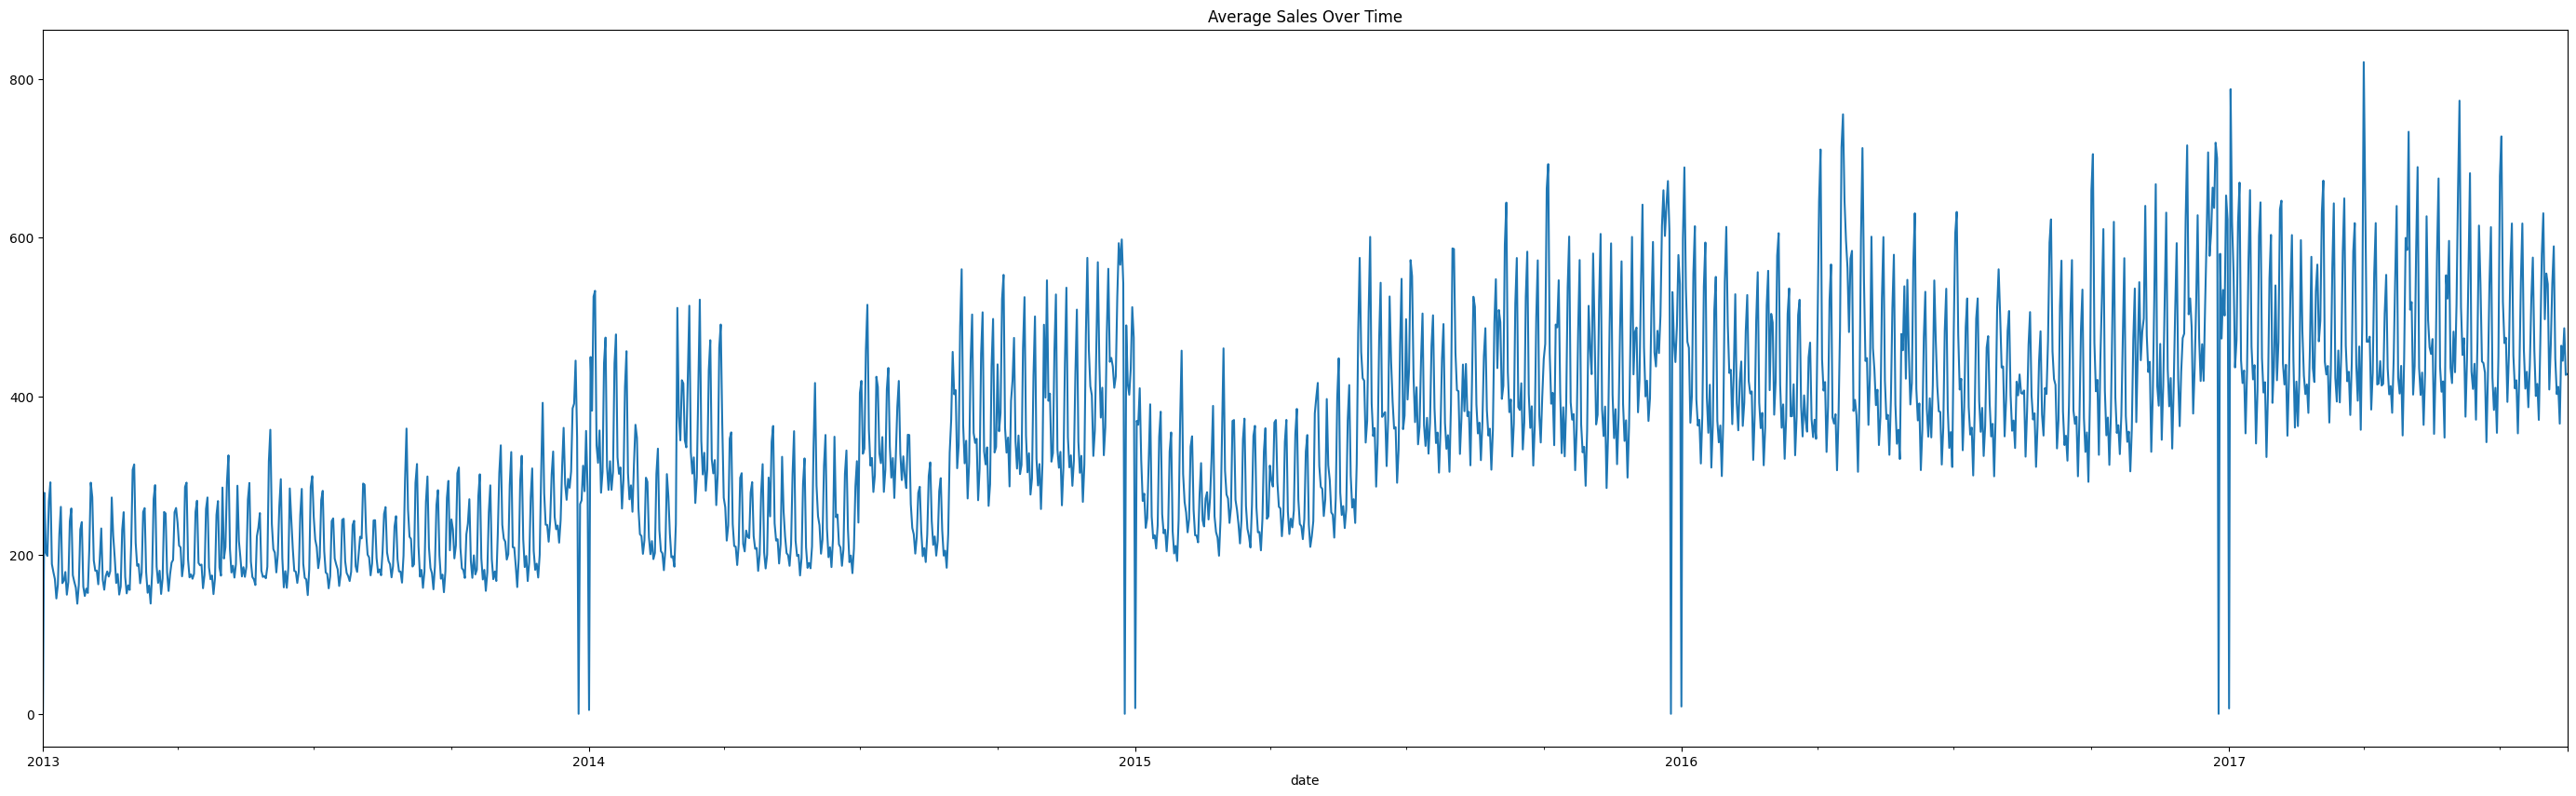

In [21]:
plt.figure(figsize=(35, 10))
processed_data_train.groupby('date')['sales'].mean().plot()
plt.title('Average Sales Over Time')
plt.show()


Text(0.5, 1.0, 'Oil Price Over Time')

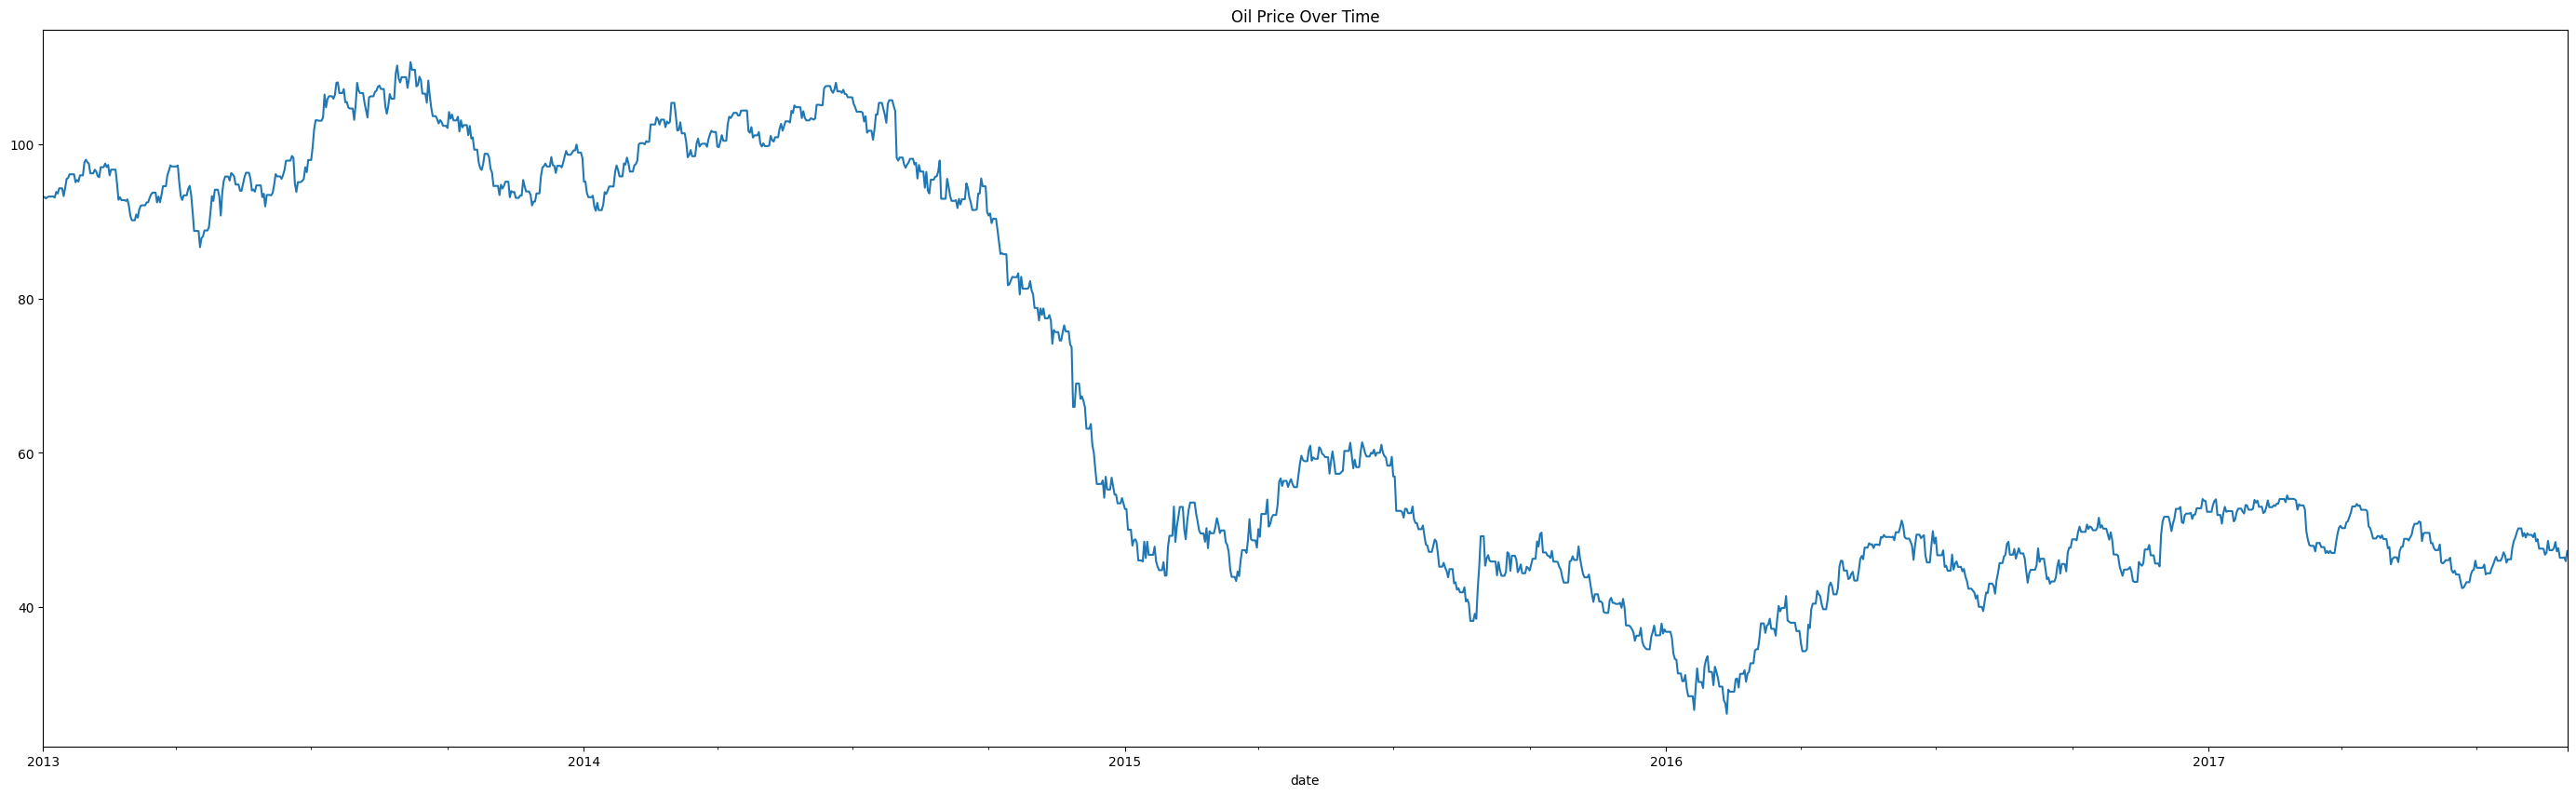

In [22]:
plt.figure(figsize=(35, 10))
processed_data_oil.set_index('date')['dcoilwtico'].plot()
plt.title('Oil Price Over Time')

Text(0.5, 1.0, 'Sales by Top 10 Product Families')

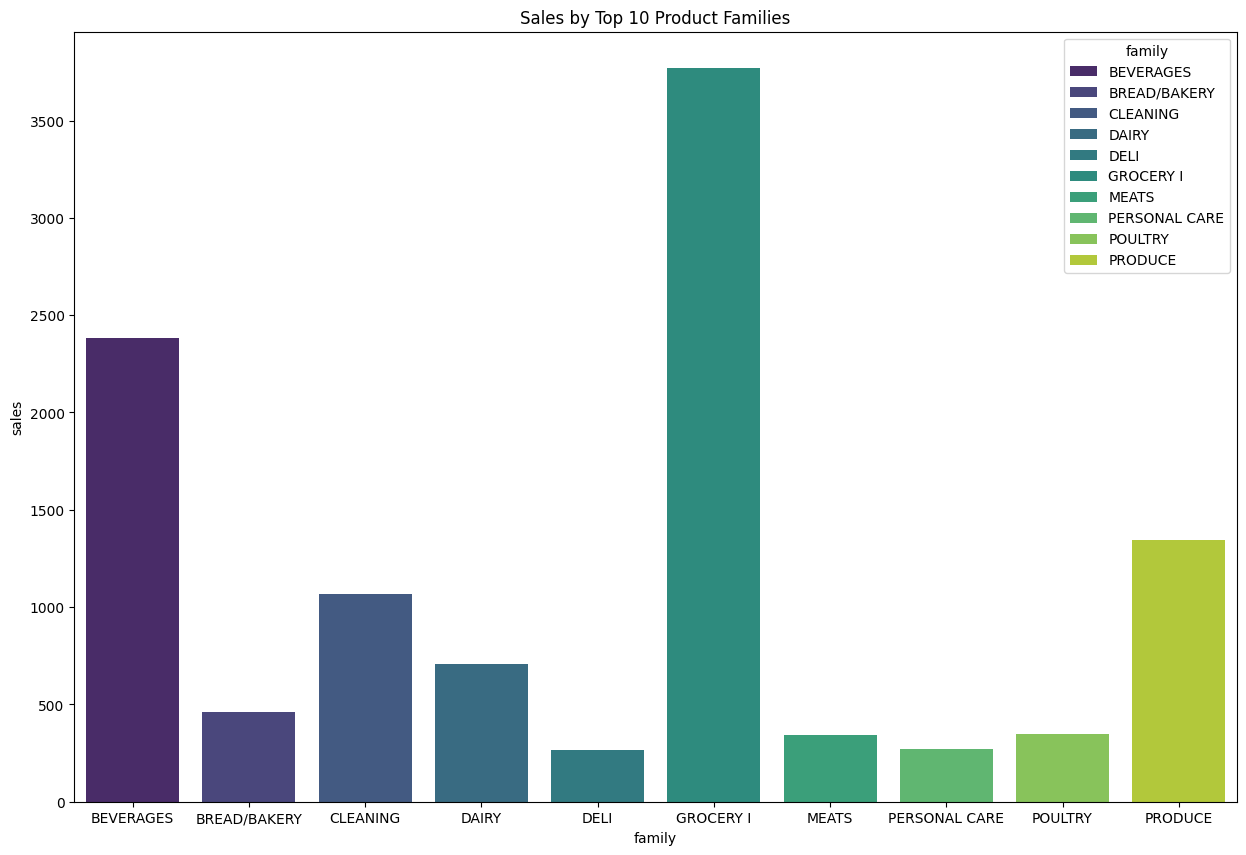

In [23]:
plt.figure(figsize=(15, 10))
top_10_families = processed_data_train.groupby('family')['sales'].sum().sort_values(ascending=False).head(10).index
top_10_families_data = processed_data_train[processed_data_train['family'].isin(top_10_families)]
sns.barplot(x='family', y='sales', data=top_10_families_data, errorbar=None, palette='viridis', hue='family', dodge=False)
plt.title('Sales by Top 10 Product Families')


<Axes: xlabel='city', ylabel='sales'>

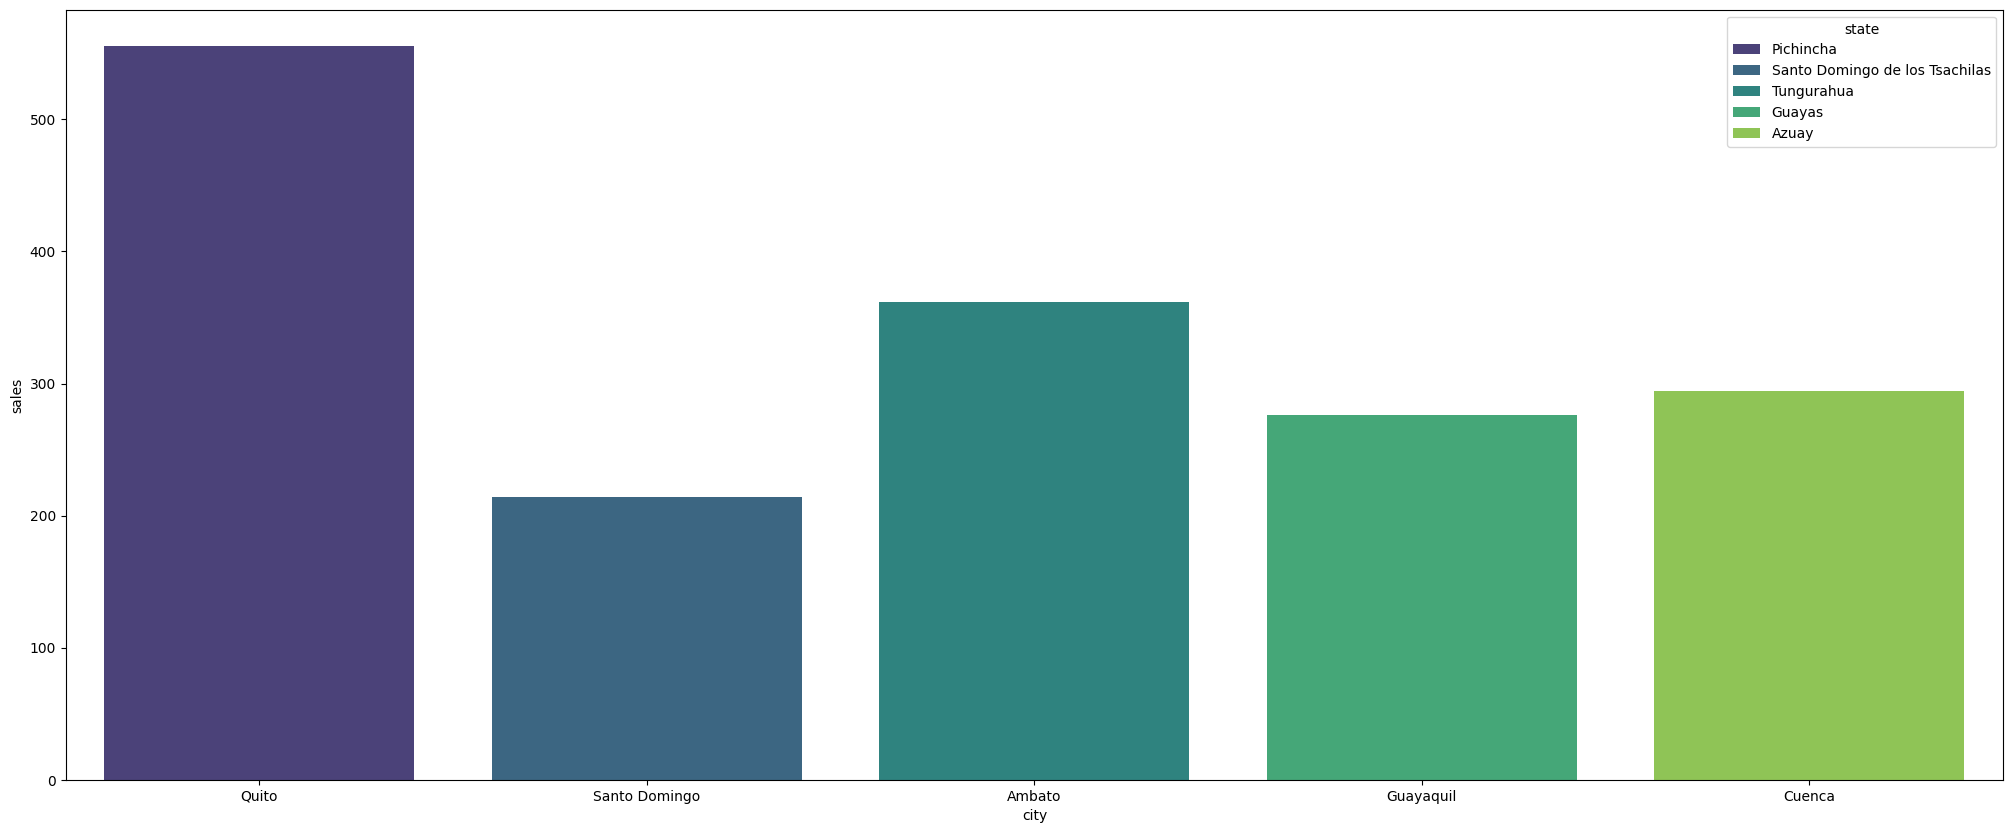

In [24]:
plt.figure(figsize=(25, 10))
store_and_sales = processed_data_train.merge(data_stores, on='store_nbr', how='left')
top_5_cities = store_and_sales.groupby('city')['sales'].sum().sort_values(ascending=False).head(5).index

top_5_cities_data = store_and_sales[store_and_sales['city'].isin(top_5_cities)]
sns.barplot(x='city', y='sales', data=top_5_cities_data, palette='viridis', errorbar=None, hue='state', dodge=False)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


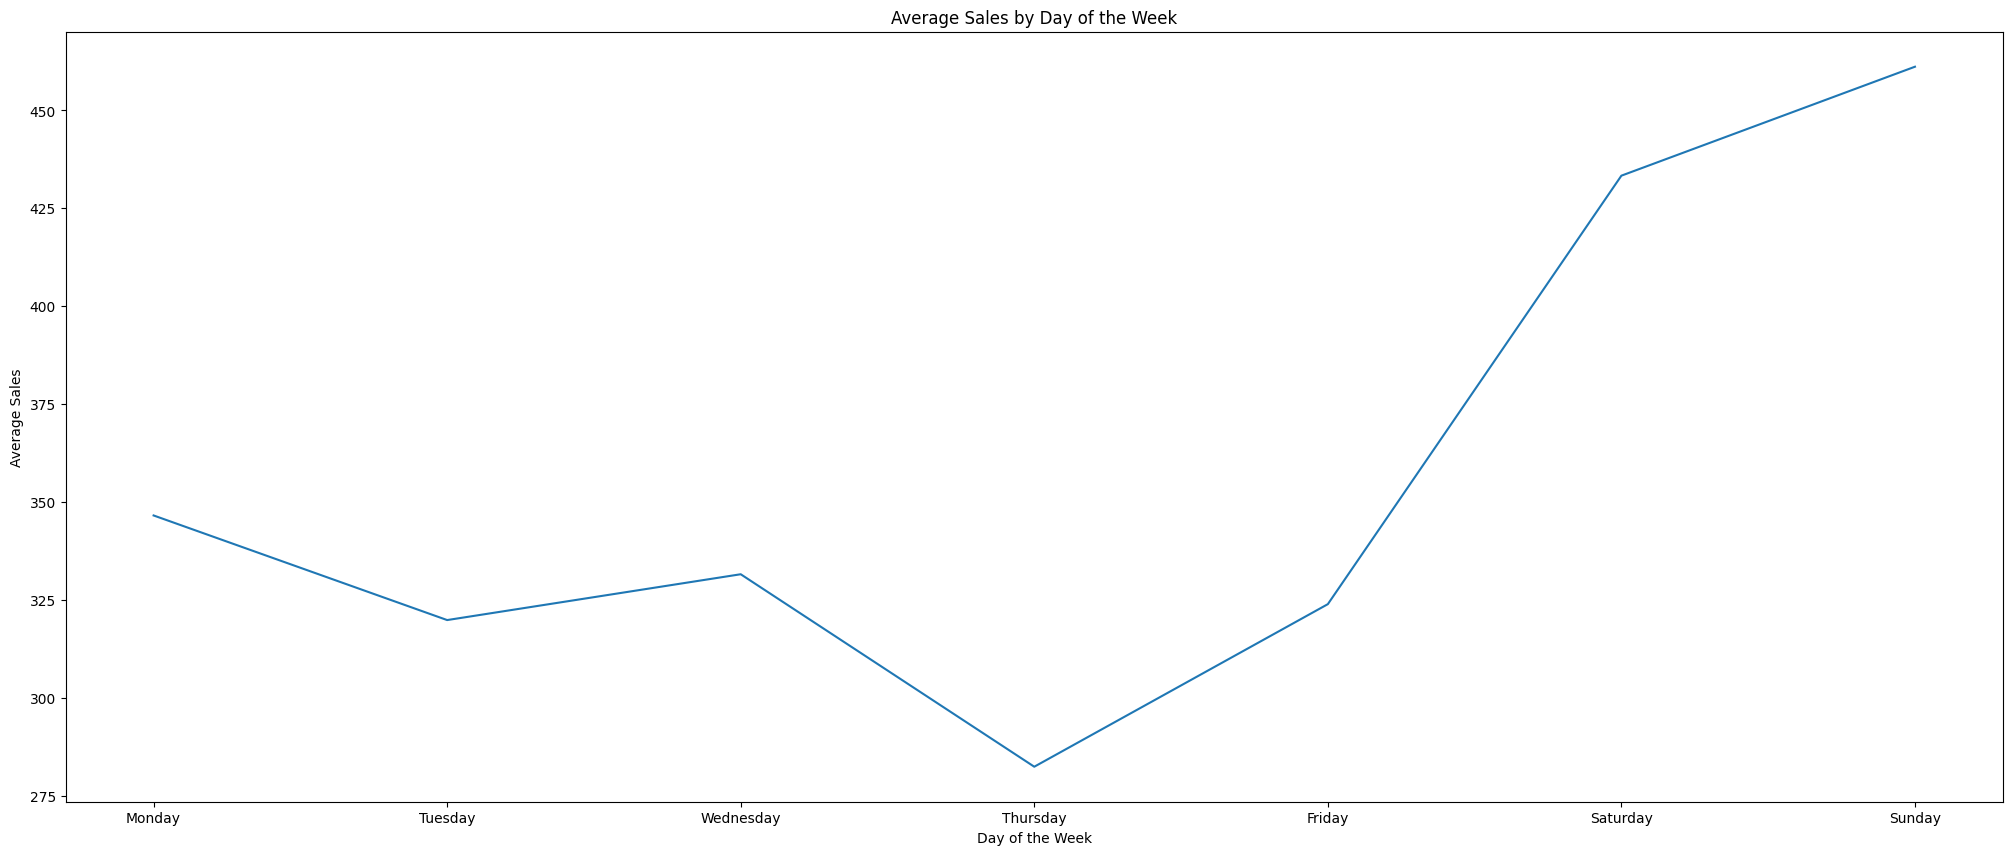

In [25]:
processed_data_train['day_of_week'] = processed_data_train['date'].dt.dayofweek
processed_data_train['day_of_week'] = processed_data_train['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
processed_data_train['day_of_week'] = pd.Categorical(processed_data_train['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(25, 10))
sns.lineplot(x='day_of_week', y='sales', data=processed_data_train, estimator='mean', errorbar=None)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.show()
processed_data_train.drop('day_of_week', axis=1, inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


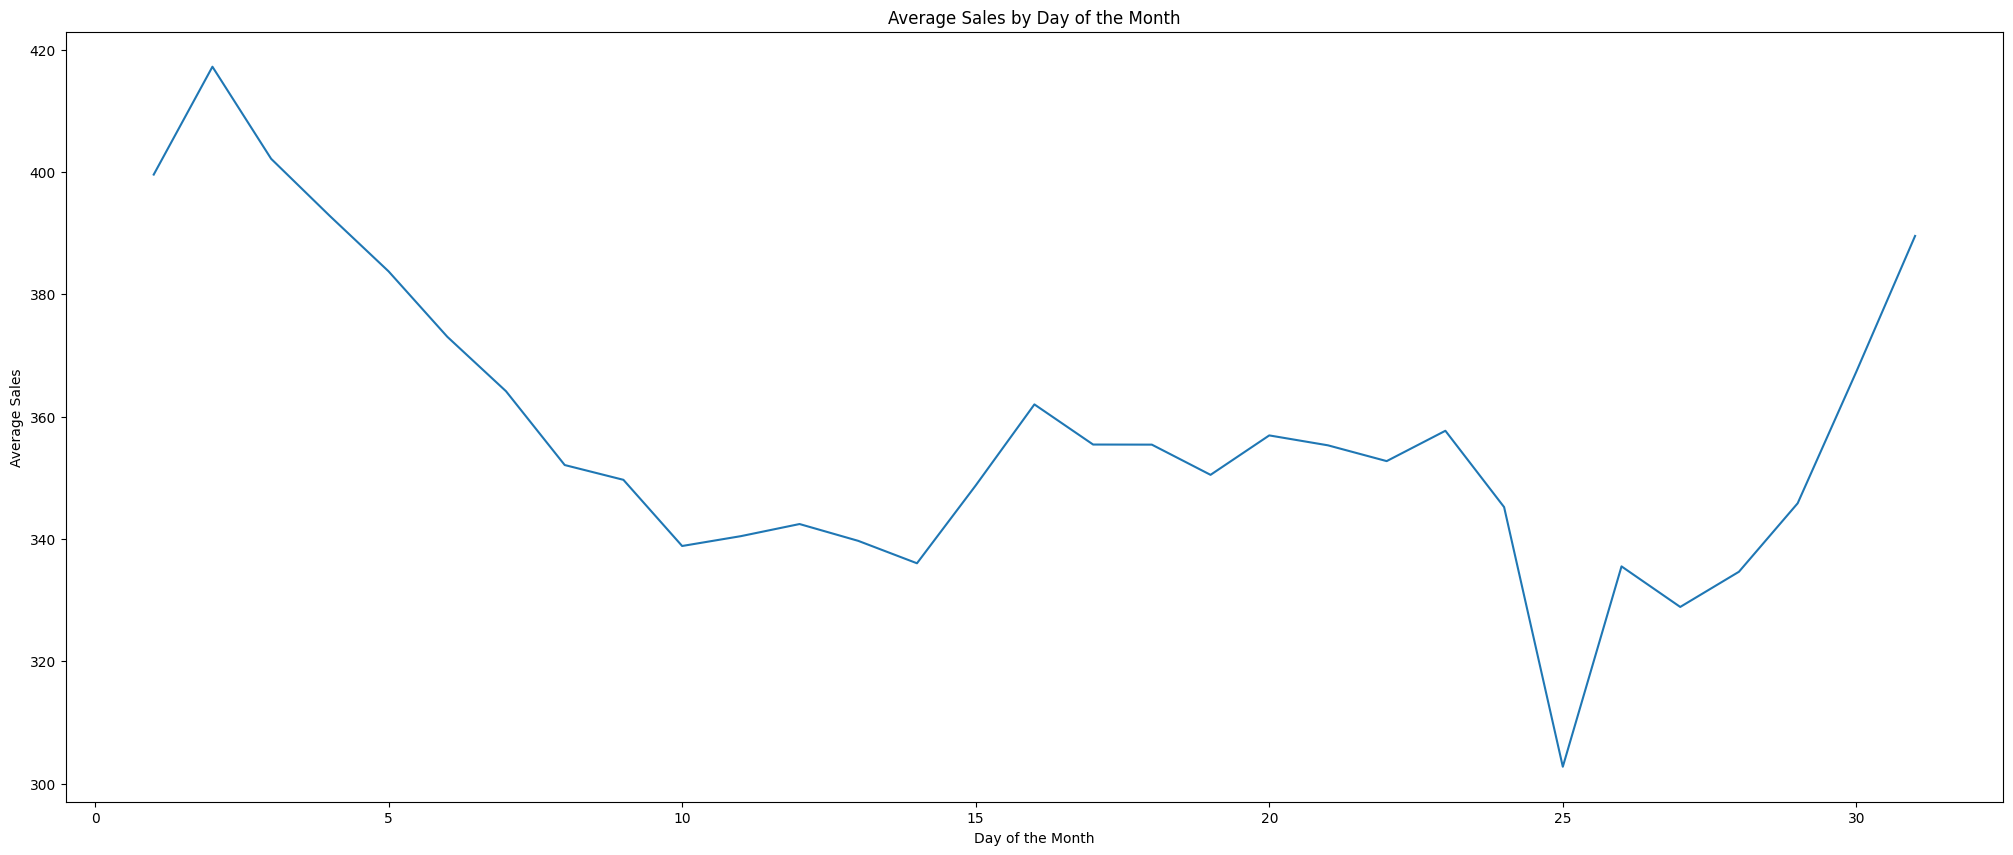

In [26]:
processed_data_train['day_of_month'] = processed_data_train['date'].dt.day

plt.figure(figsize=(25, 10))
sns.lineplot(x='day_of_month', y='sales', data=processed_data_train, estimator='mean', errorbar=None)
plt.title('Average Sales by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Sales')
plt.show()
processed_data_train.drop('day_of_month', axis=1, inplace=True)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


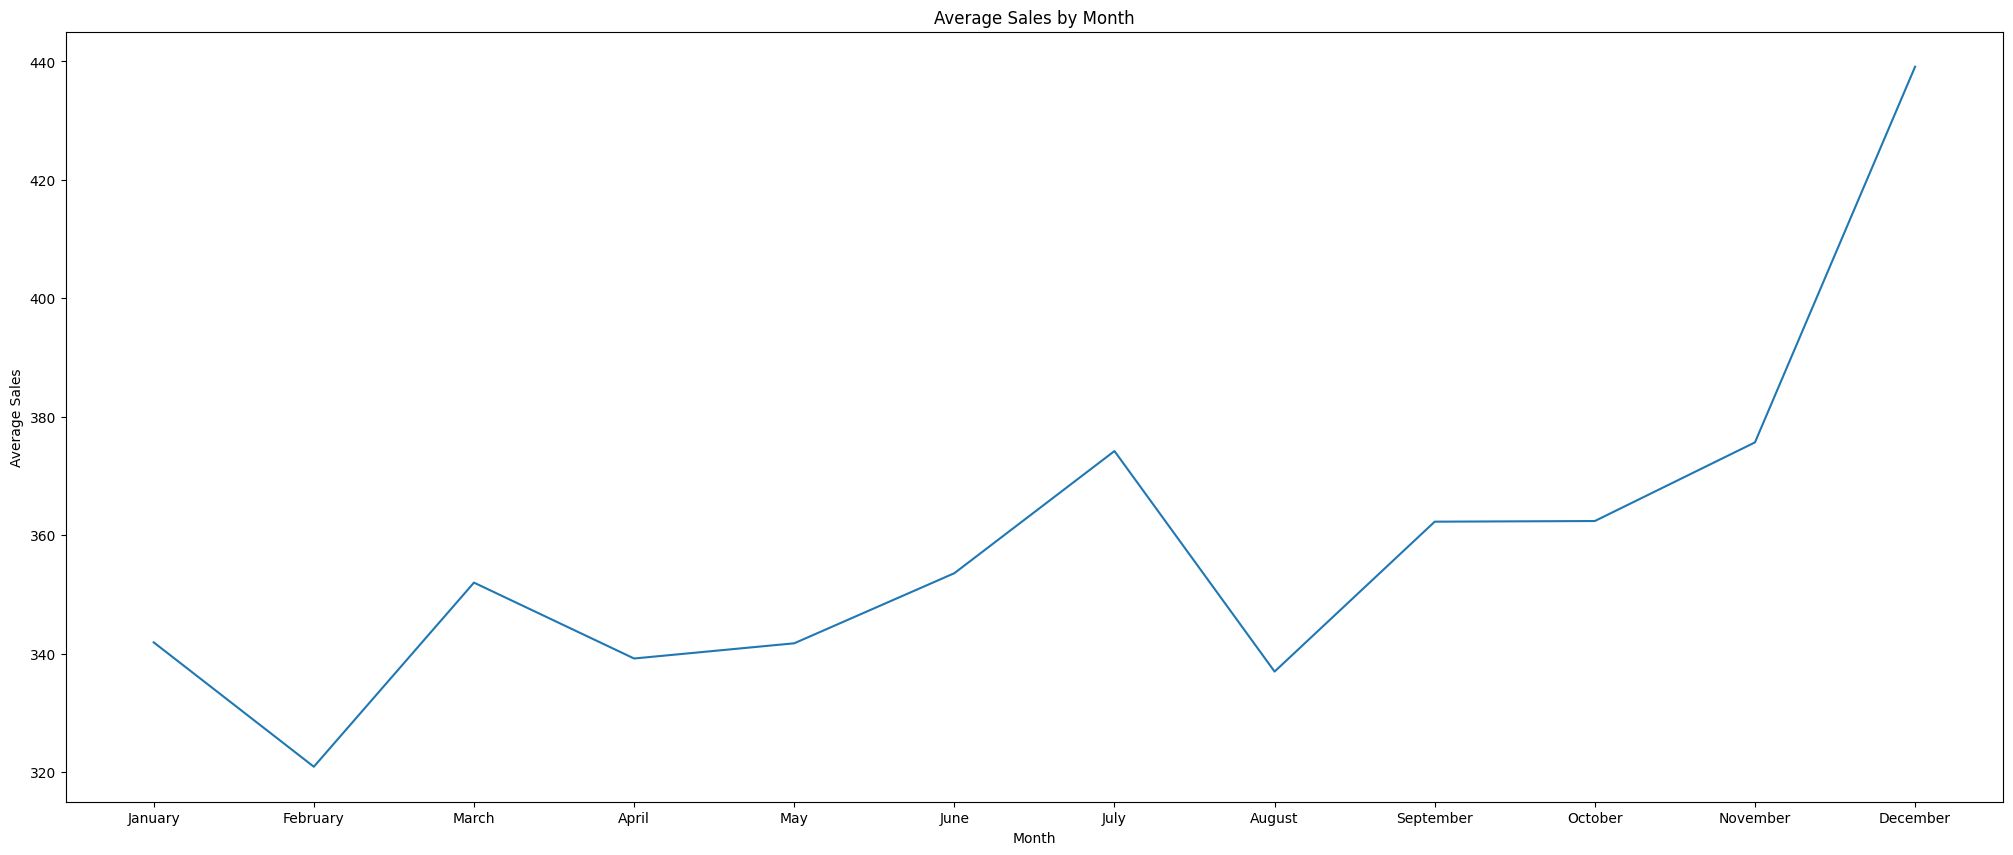

In [27]:
processed_data_train['month'] = processed_data_train['date'].dt.month
processed_data_train['month'] = processed_data_train['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Set the correct order for the months
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
processed_data_train['month'] = pd.Categorical(processed_data_train['month'], categories=months_order, ordered=True)

# Plot average sales by month
plt.figure(figsize=(25, 10))
sns.lineplot(x='month', y='sales', data=processed_data_train, estimator='mean', errorbar=None)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()
processed_data_train.drop('month', axis=1, inplace=True)

Final thoughts:

1. The products with most sales are, by far, Grocery I and Beverages.
2. The sales are way higher on weekends.
3. The sales skyrocket on the december.
4. The sales are higher on the 2nd day of the month, and on the 16th which is a day after the wages are paid.


# Preprocessing and Feature Engineering

We will first start by predicting the value of transactions made by each store. Once we have the transactions, we will predict the sales of each item in each store. 

Before we get to that we will transform the data to make it easier to work with and create a pipeline to make the process easier.

GridSearchCV will be used to find the best parameters for the models we will use.

In [28]:
#merging the data sets for both train and test
final_data_train = processed_data_train.merge(
    data_transactions, on=["date", "store_nbr"], how="left",
).merge(
    processed_data_oil, on="date", how="left",
).merge(
    data_stores, on="store_nbr", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

final_data_train['transactions'] = final_data_train['transactions'].fillna(0.0)

final_data_test = data_test.merge(
    processed_data_oil, on="date", how="left",
).merge(
    data_stores, on="store_nbr", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

In [29]:
#creating a mask for the events
events = (processed_data_holidays['type'] == 'Event') & (~processed_data_holidays['date'].isin(earthquake_range))
local_holidays = (processed_data_holidays['locale'] == 'Local') & (processed_data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))
regional_holidays = (processed_data_holidays['locale'] == 'Regional') & (processed_data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))
national_holidays = (processed_data_holidays['locale'] == 'National') & (processed_data_holidays['type'].isin(['Holiday', 'Additional', 'Bridge']))

In [30]:
#creating columns for the events that will be used in the model
final_data_train['is_event_day'] = 0
final_data_train['is_holiday'] = 0
final_data_train['affected_by_earthquake'] = 0
final_data_train['is_pay_day'] = 0

# events
final_data_train.loc[final_data_train['date'].isin(processed_data_holidays.loc[events, 'date']), 'is_event_day'] = 1

# local holidays
for _, row in processed_data_holidays[local_holidays].iterrows():
    final_data_train.loc[(final_data_train['city'] == row['locale_name']) & (final_data_train['date'] == row['date']), 'is_holiday'] = 1

# regional holidays
for _, row in processed_data_holidays[regional_holidays].iterrows():
    final_data_train.loc[(final_data_train['state'] == row['locale_name']) & (final_data_train['date'] == row['date']), 'is_holiday'] = 1

# national holidays
final_data_train.loc[final_data_train['date'].isin(processed_data_holidays.loc[national_holidays, 'date']), 'is_holiday'] = 1

# earthquake
final_data_train.loc[final_data_train["date"].isin(earthquake_range), "affected_by_earthquake"] = 1

# paydays
final_data_train.loc[(final_data_train['date'].dt.day == 15) | (final_data_train['date'].dt.is_month_end), 'is_pay_day'] = 1

# weekends
final_data_train.loc[final_data_train['date'].dt.weekday.isin([5, 6]), 'is_holiday'] = 1

# add day, day of week, week of year, month, quarter and year
final_data_train['day'] = final_data_train['date'].dt.day
final_data_train['dayofweek'] = final_data_train['date'].dt.dayofweek
final_data_train['weekofyear'] = final_data_train['date'].dt.isocalendar().week
final_data_train['month'] = final_data_train['date'].dt.month
final_data_train['quarter'] = final_data_train['date'].dt.quarter
final_data_train['year'] = final_data_train['date'].dt.year

le = LabelEncoder()

final_data_train['city'] = le.fit_transform(final_data_train['city'])
final_data_train['state'] = le.fit_transform(final_data_train['state'])
final_data_train['type'] = le.fit_transform(final_data_train['type'])
final_data_train['cluster'] = le.fit_transform(final_data_train['cluster'])
final_data_train['family'] = le.fit_transform(final_data_train['family'])

In [31]:
#same thing for the test data
final_data_test['is_event_day'] = 0
final_data_test['is_holiday'] = 0
final_data_test['affected_by_earthquake'] = 0
final_data_test['is_pay_day'] = 0

# events
final_data_test.loc[final_data_test['date'].isin(processed_data_holidays.loc[events, 'date']), 'is_event_day'] = 1

# local holidays
for _, row in processed_data_holidays[local_holidays].iterrows():
    final_data_test.loc[(final_data_test['city'] == row['locale_name']) & (final_data_test['date'] == row['date']), 'is_holiday'] = 1

# regional holidays
for _, row in processed_data_holidays[regional_holidays].iterrows():
    final_data_test.loc[(final_data_test['state'] == row['locale_name']) & (final_data_test['date'] == row['date']), 'is_holiday'] = 1

# national holidays
final_data_test.loc[final_data_test['date'].isin(processed_data_holidays.loc[national_holidays, 'date']), 'is_holiday'] = 1

# earthquake
final_data_test.loc[final_data_test["date"].isin(earthquake_range), "affected_by_earthquake"] = 1

# paydays
final_data_test.loc[(final_data_test['date'].dt.day == 15) | (final_data_test['date'].dt.is_month_end), 'is_pay_day'] = 1

# weekends
final_data_test.loc[final_data_test['date'].dt.weekday.isin([5, 6]), 'is_holiday'] = 1

# add day, day of week, week of year, month, quarter and year
final_data_test['day'] = final_data_test['date'].dt.day
final_data_test['dayofweek'] = final_data_test['date'].dt.dayofweek
final_data_test['weekofyear'] = final_data_train['date'].dt.isocalendar().week
final_data_test['month'] = final_data_test['date'].dt.month
final_data_test['quarter'] = final_data_test['date'].dt.quarter
final_data_test['year'] = final_data_test['date'].dt.year

le = LabelEncoder()

final_data_test['city'] = le.fit_transform(final_data_test['city'])
final_data_test['state'] = le.fit_transform(final_data_test['state'])
final_data_test['type'] = le.fit_transform(final_data_test['type'])
final_data_test['cluster'] = le.fit_transform(final_data_test['cluster'])
final_data_test['family'] = le.fit_transform(final_data_test['family'])

In [32]:
#reordering the columns, excluding the two targets and two created for EDA
columns_to_exclude = ["sales", "transactions", "day_of_week", "day_of_month"]
train_column_order = [col for col in final_data_train.columns if col not in columns_to_exclude]

final_data_test = final_data_test[train_column_order]

# Training

We will use the following models:

1. Linear Regression (baseline)
2. Random Forest
3. Decision Tree
4. Gradient Boosting

All of the results were uploaded to the leaderboard individually, here are the results (less is better):

1. Linear Regression: 3.00495
2. Random Forest: 0.58009
3. Decision Tree: 0.65645
4. Gradient Boosting: 1.47753

<Axes: xlabel='Model', ylabel='Score'>

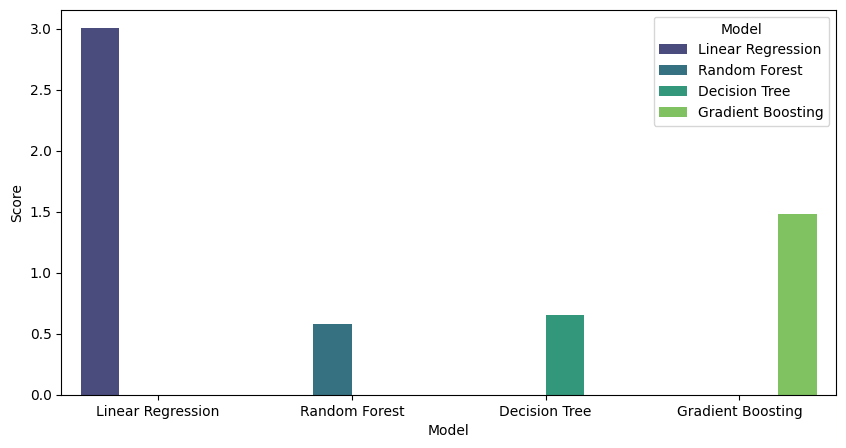

In [33]:
data = [
    ['Linear Regression', 3.00495],
    ['Random Forest', 0.58009],
    ['Decision Tree', 0.65645],
    ['Gradient Boosting', 1.47753]
]

results = pd.DataFrame(data, columns=['Model', 'Score'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Score', data=results, palette='viridis', hue='Model')


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

X = final_data_train.drop(columns=['date', 'transactions', 'sales'])
y = final_data_train['transactions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressors = {
    'linear_regression': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'decision_tree': DecisionTreeRegressor(),
    'xgboost': XGBRegressor(),
}

pipeline_transactions = Pipeline([
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor': list(regressors.values()),
}

grid_search = GridSearchCV(pipeline_transactions, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best model: ", grid_search.best_estimator_)
print("Best score: ", grid_search.best_score_)
print("Test score: ", mean_squared_error(y_test, grid_search.predict(X_test)))


Best model:  Pipeline(steps=[('regressor', RandomForestRegressor())])
Best score:  -3.6386697636978114
Test score:  3.2965080459903855


The best regressor was the RandomForestRegressor, which we will use to predict the sales. 

In [35]:
final_data_test['transactions'] = grid_search.predict(final_data_test.drop(columns=['date']))

In [36]:
X = final_data_train.drop(columns=['date', 'sales'])
y = final_data_train['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor()

regressor.fit(X_train, y_train)

RandomForestRegressor()

In [37]:
columns_to_exclude = ["sales"]
train_column_order = [col for col in final_data_train.columns if col not in columns_to_exclude]

final_data_test = final_data_test[train_column_order]

y_pred = regressor.predict(final_data_test.drop(columns=['date']))

final_data_test['sales'] = y_pred

final_data_test[['id', 'sales']].to_csv('submission.csv', index=False)